# Keywords matching and relevance index ranking 

In [33]:
# import packages
import pandas as pd
import numpy as np
import math
from nltk import ngrams
from matplotlib import pyplot as plt

In [34]:
# import internal modules
import file_path_management as fpath
import public_library as plib
import parameters as params
import download_and_process_pdf as dpp
import dataframe_columns as df_col

## Predefined fucntions:

In [35]:
def relevance_index(counts_dict):
    index = 0
    for key in counts_dict.keys():
        index += math.log(1+counts_dict[key]) * (params.ranking_kw_groups_weights[key])
    return index
# --------------------start of test code--------------------
# keywords_count_or_fre = {}
# index = calcul_related(keywords_count_or_fre, params.on_topic_kws_weights)
# print(index)
# ---------------------end of test code---------------------

In [36]:
def compute_relevance_index(db_count_path, db_relevance_index):
    df = pd.read_csv(db_count_path, header=0, sep="\t")
    
    for ind in df.index:
        count_dict_tak = {}
        for key in params.ranking_kw_groups.keys():
            value = df.at[ind, key+"_COUNT_IN_TAK"]
            if value != value:
                value = 0
            count_dict_tak[key] = int(value)
        # print(count_dict_tak)
        
        count_dict_500 = {}
        for key in params.ranking_kw_groups.keys():
            value = df.at[ind, key+"_COUNT_IN_500"]
            if value != value:
                value = 0
            count_dict_500[key] = int(value)
        # print(count_dict_500)
        
        count_dict_full_text = {}
        for key in params.ranking_kw_groups.keys():
            value = df.at[ind, key+"_COUNT_IN_FULL_TEXT"]
            if value != value:
                value = 0
            count_dict_full_text[key] = int(value)
        # print(count_dict_full_text)

        relev_index_tak = relevance_index(count_dict_tak)
        relev_index_500 = relevance_index(count_dict_500)
        relev_index_full_text = relevance_index(count_dict_full_text)
        
        df.at[ind, "RELEVANCE_INDEX_TAK"] = relev_index_tak
        df.at[ind, "RELEVANCE_INDEX_500"] = relev_index_500
        df.at[ind, "RELEVANCE_INDEX_FULL_TEXT"] = relev_index_full_text
        
        line_number_in_csv = ind + 1
        print("Line number:", line_number_in_csv, " INDEX:", int(df.at[ind, "INDEX"]))
    
    df.columns = df_col.db_ranked_columns
    df.reset_index(drop=True, inplace=True)
    df.to_csv(db_relevance_index, header=True, index=False, sep="\t")
    
    print("Weighting and ranking the potentially related literature succeded!")
    print("Enjoy reading!")
# --------------------start of test code--------------------
# input_path = fpath.poten_litera_db_kw_count
# output_path = fpath.poten_litera_db_ranked
# rank(input_path, output_path, params.ranking_params_weights)
# ---------------------end of test code---------------------

In [37]:
def rank(by):
    # sort
    df_to_rank = pd.read_csv(fpath.poten_litera_db_relevance_index, header=0, sep="\t")
    
    if by == "tak":
        # sort the dataframe by RELEVANCE_INDEX_TAK
        df_to_rank.sort_values(by=['RELEVANCE_INDEX_TAK'], inplace=True, ascending=False)
    elif by == '500':
        # sort the dataframe by RELEVANCE_INDEX_500
        df_to_rank.sort_values(by=['RELEVANCE_INDEX_500'], inplace=True, ascending=False)
    elif by == 'full_text':
        # sort the dataframe by RELEVANCE_INDEX_FULL_TEXT
        df_to_rank.sort_values(by=['RELEVANCE_INDEX_FULL_TEXT'], inplace=True, ascending=False)
    else:
        raise Exception("Invalid input!")
    
    df_to_rank.reset_index(drop=True, inplace=True)
    
    return df_to_rank

## Main program:

### 1. Calculate relevance index

In [38]:
input_path = fpath.poten_litera_db_kw_count
output_path = fpath.poten_litera_db_relevance_index

# clear file
plib.clear_file(output_path)

compute_relevance_index(input_path, output_path)

Line number: 1  INDEX: 0
Line number: 2  INDEX: 1
Line number: 3  INDEX: 2
Line number: 4  INDEX: 4
Line number: 5  INDEX: 5
Line number: 6  INDEX: 6
Line number: 7  INDEX: 7
Line number: 8  INDEX: 8
Line number: 9  INDEX: 9
Line number: 10  INDEX: 10
Line number: 11  INDEX: 11
Line number: 12  INDEX: 12
Line number: 13  INDEX: 13
Line number: 14  INDEX: 14
Line number: 15  INDEX: 15
Line number: 16  INDEX: 16
Line number: 17  INDEX: 17
Line number: 18  INDEX: 18
Line number: 19  INDEX: 19
Line number: 20  INDEX: 20
Line number: 21  INDEX: 21
Line number: 22  INDEX: 22
Line number: 23  INDEX: 23
Line number: 24  INDEX: 24
Line number: 25  INDEX: 25
Line number: 26  INDEX: 26
Line number: 27  INDEX: 27
Line number: 28  INDEX: 28
Line number: 29  INDEX: 29
Line number: 30  INDEX: 30
Line number: 31  INDEX: 31
Line number: 32  INDEX: 32
Line number: 33  INDEX: 33
Line number: 34  INDEX: 34
Line number: 35  INDEX: 35
Line number: 36  INDEX: 36
Line number: 37  INDEX: 37
Line number: 38  IN

Line number: 385  INDEX: 395
Line number: 386  INDEX: 396
Line number: 387  INDEX: 397
Line number: 388  INDEX: 398
Line number: 389  INDEX: 399
Line number: 390  INDEX: 400
Line number: 391  INDEX: 401
Line number: 392  INDEX: 402
Line number: 393  INDEX: 403
Line number: 394  INDEX: 404
Line number: 395  INDEX: 405
Line number: 396  INDEX: 407
Line number: 397  INDEX: 408
Line number: 398  INDEX: 409
Line number: 399  INDEX: 410
Line number: 400  INDEX: 411
Line number: 401  INDEX: 412
Line number: 402  INDEX: 413
Line number: 403  INDEX: 414
Line number: 404  INDEX: 415
Line number: 405  INDEX: 416
Line number: 406  INDEX: 417
Line number: 407  INDEX: 419
Line number: 408  INDEX: 420
Line number: 409  INDEX: 421
Line number: 410  INDEX: 422
Line number: 411  INDEX: 423
Line number: 412  INDEX: 424
Line number: 413  INDEX: 425
Line number: 414  INDEX: 426
Line number: 415  INDEX: 427
Line number: 416  INDEX: 428
Line number: 417  INDEX: 429
Line number: 418  INDEX: 430
Line number: 4

### 2. Candidate articles ranking based on relevance index

In [39]:
# read from poten_litera_db_kw_count, rank the candidate articles, save to poten_litera_db_ranked
input_path = fpath.poten_litera_db_relevance_index
# output_path = fpath.poten_litera_db_ranked

# # clear file
# plib.clear_file(output_path)

df_ranked_by_tak = rank('tak')
df_ranked_by_500 = rank('500')
df_ranked_by_full_text = rank('full_text')

### Ranking results analysis

In [40]:
# read the ranked database and obtain the relevance_index of YESs and NOs 
# of the test data set and draw a violin plot, and calculate the difference between the two distributions
# the difference is defined as 1. t-statistic 2. 
test_path = fpath.poten_litera_testing_set_1000_labeled
df_test = pd.read_csv(test_path, header=0, sep=',')

In [41]:
# save the counts of the keywords in the respective lists
relevant_species = []
relevant_other_species = []
relevant_tc_ct = []
relevant_thalam = []
relevant_cortex = []
relevant_inject = []
relevant_method = []
relevant_connectivity = []

non_relevant_species = []
non_relevant_other_species = []
non_relevant_tc_ct = []
non_relevant_thalam = []
non_relevant_cortex = []
non_relevant_inject = []
non_relevant_method = []
non_relevant_connectivity = []

relvant_index = []
relevant_relevance_index_list = []

non_relevant_index = []
non_relevant_relevance_index_list = []

df_ranked_by_tak = rank('tak')
df_ranked_by_500 = rank('500')
df_ranked_by_full_text = rank('full_text')

df_db_ranked = df_ranked_by_tak
column_name_base = "TAK"
# df_db_ranked = df_ranked_by_500
# column_name_base = "500"
# df_db_ranked = df_ranked_by_full_text
# column_name_base = "FULL_TEXT"

for ind in df_test.index:
    index = int(df_test.at[ind, "INDEX"])
    # print(ind, index)
    # print(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "RELEVANCE_INDEX"].values[0])

    # if df_test.at[ind, "RELEVANT"] == "YES" and df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "LENGTH_TEXT"].values[0] > 100:
    if df_test.at[ind, "RELEVANT?(Y/N/MB/NA)"] == "Y":
        relvant_index.append(index)
        relevant_relevance_index_list.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "RELEVANCE_INDEX_"+column_name_base].values[0])
        relevant_species.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "MACAQUE_COUNT_IN_"+column_name_base].values[0])
        relevant_other_species.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "OTHER_SPIECIES_COUNT_IN_"+column_name_base].values[0])
        relevant_tc_ct.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "TC_CT_COUNT_IN_"+column_name_base].values[0])
        relevant_thalam.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "THALAM_COUNT_IN_"+column_name_base].values[0])
        relevant_cortex.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "CORTEX_COUNT_IN_"+column_name_base].values[0])
        relevant_inject.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "INJECT_COUNT_IN_"+column_name_base].values[0])
        relevant_method.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "METHOD_COUNT_IN_"+column_name_base].values[0])
        relevant_connectivity.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "CONNECT_COUNT_IN_"+column_name_base].values[0])
    # elif df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "LENGTH_TEXT"].values[0] > 100:
    else:
        non_relevant_index.append(index)
        non_relevant_relevance_index_list.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "RELEVANCE_INDEX_"+column_name_base].values[0])
        non_relevant_species.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "MACAQUE_COUNT_IN_"+column_name_base].values[0])
        non_relevant_other_species.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "OTHER_SPIECIES_COUNT_IN_"+column_name_base].values[0])
        non_relevant_tc_ct.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "TC_CT_COUNT_IN_"+column_name_base].values[0])
        non_relevant_thalam.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "THALAM_COUNT_IN_"+column_name_base].values[0])
        non_relevant_cortex.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "CORTEX_COUNT_IN_"+column_name_base].values[0])
        non_relevant_inject.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "INJECT_COUNT_IN_"+column_name_base].values[0])
        non_relevant_method.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "METHOD_COUNT_IN_"+column_name_base].values[0])
        non_relevant_connectivity.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "CONNECT_COUNT_IN_"+column_name_base].values[0])

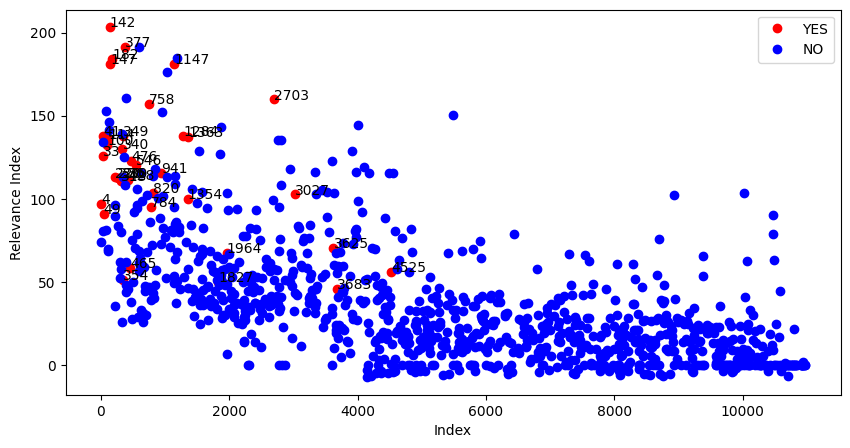

In [42]:
# plot the dot plot of the relevance_index of YESs and NOs of the test data set
plt.figure(figsize=(10, 5))
plt.plot(relvant_index, relevant_relevance_index_list, 'ro', label="YES")
plt.plot(non_relevant_index, non_relevant_relevance_index_list, 'bo', label="NO")
plt.xlabel("Index")
plt.ylabel("Relevance Index")
plt.legend()

# add labels for the relevant index points
for i, index in enumerate(relvant_index):
    plt.text(index, relevant_relevance_index_list[i]+0.1, str(index), color='black', fontsize=10)

# # add labels for the relevant index points
# for i, index in enumerate(non_relevant_index):
#     plt.text(index, non_relevant_relevance_index_list[i], str(index), color='black', fontsize=10)

plt.show()

In [43]:
# for i in range(len(relvant_index)):
    # print(relvant_index[i], relevant_relevance_index_list[i])
    # print(relevant_relevance_index_list)
    
# min_relev_index = min(relevant_relevance_index_list)
min_relev_index_index = 3683

# Get the selected relevant articles
# db_ranked_path = fpath.poten_litera_db_ranked
# df_db_ranked = pd.read_csv(db_ranked_path, header=0, sep=',')

for ind in df_db_ranked.index:
    if df_db_ranked.at[ind, "INDEX"] == min_relev_index_index:
        min_relev_index_ind = ind
        break 
# print(min_relev_index_ind)

min_relev_index_num = min_relev_index_ind  + 1
num = math.ceil(min_relev_index_num * 1.3)

threshold_index = df_db_ranked.at[num-1, 'INDEX']
print(f"The index with the minimum relevance index: {min_relev_index_index}")
print(f"The number of articles with relevance index larger or equal than {min_relev_index_index}: {min_relev_index_num}")
print(f"The index of the article with the threshold relevance index: {threshold_index}")
print(f"The number of articles to manually check is {num}")

The index with the minimum relevance index: 3683
The number of articles with relevance index larger or equal than 3683: 2980
The index of the article with the threshold relevance index: 1866
The number of articles to manually check is 3874


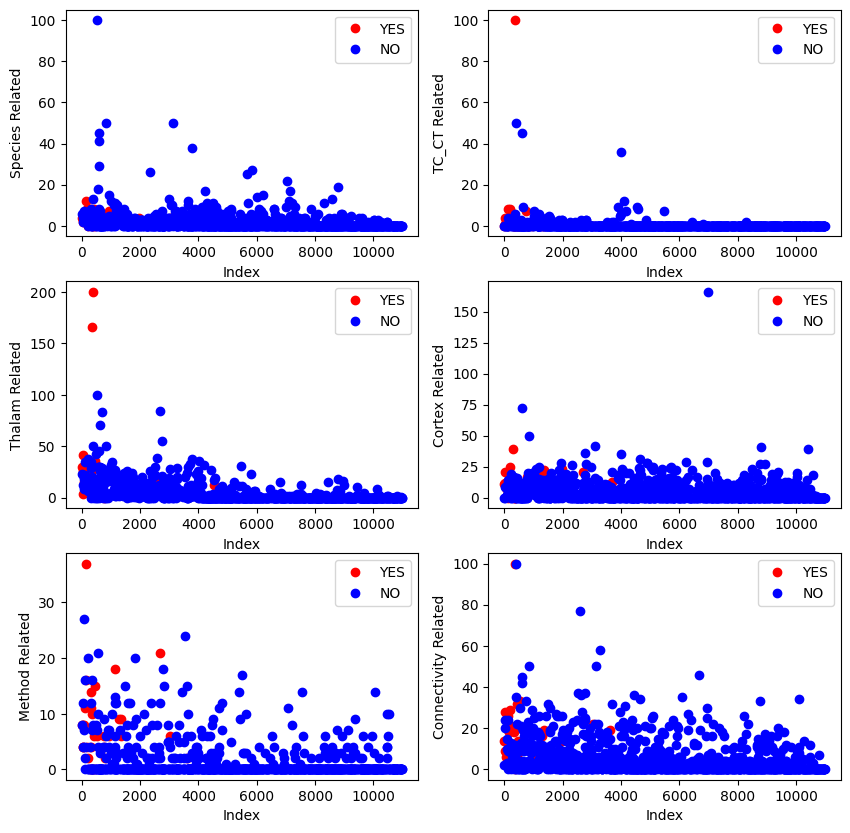

In [44]:
# plot the 6 dot plots of the species_related, tc_ct_related, thalam_related, cortex_related, method_related, connectivity_related of YESs and NOs of the test data set in 2 rows in the same figure
plt.figure(figsize=(10, 10))
plt.subplot(3, 2, 1)
plt.plot(relvant_index, relevant_species, 'ro', label="YES")
plt.plot(non_relevant_index, non_relevant_species, 'bo', label="NO")
plt.xlabel("Index")
plt.ylabel("Species Related")
plt.legend()

plt.subplot(3, 2, 2)
plt.plot(relvant_index, relevant_tc_ct, 'ro', label="YES")
plt.plot(non_relevant_index, non_relevant_tc_ct, 'bo', label="NO")
plt.xlabel("Index")
plt.ylabel("TC_CT Related")
plt.legend()

plt.subplot(3, 2, 3)
plt.plot(relvant_index, relevant_thalam, 'ro', label="YES")
plt.plot(non_relevant_index, non_relevant_thalam, 'bo', label="NO")
plt.xlabel("Index")
plt.ylabel("Thalam Related")
plt.legend()

plt.subplot(3, 2, 4)
plt.plot(relvant_index, relevant_cortex, 'ro', label="YES")
plt.plot(non_relevant_index, non_relevant_cortex, 'bo', label="NO")
plt.xlabel("Index")
plt.ylabel("Cortex Related")
plt.legend()

plt.subplot(3, 2, 5)
plt.plot(relvant_index, relevant_method, 'ro', label="YES")
plt.plot(non_relevant_index, non_relevant_method, 'bo', label="NO")
plt.xlabel("Index")
plt.ylabel("Method Related")
plt.legend()

plt.subplot(3, 2, 6)
plt.plot(relvant_index, relevant_connectivity, 'ro', label="YES")
plt.plot(non_relevant_index, non_relevant_connectivity, 'bo', label="NO")
plt.xlabel("Index")
plt.ylabel("Connectivity Related")
plt.legend()

plt.show()

In [45]:
def pick_values_uniformly(data, n):
    """Pick up `n` values uniformly from `data`."""
    if n <= 0:
        return []

    # Determine the range of the data
    min_val, max_val = min(data), max(data)

    threshold = (max_val - min_val) / n / 2

    # If n is 1, just return the midpoint
    if n == 1:
        return [(min_val + max_val) / 2]

    # Calculate the interval size
    interval = (max_val - min_val) / (n - 1)

    # Get the uniform values
    return [min_val + i * interval for i in range(n)], threshold

# data = [1, 3, 5, 2, 8, 10, 2]
n = 5
density_display_index, thres = pick_values_uniformly(relevant_relevance_index_list + non_relevant_relevance_index_list, n)
print(density_display_index)

[-7.475339236566737, 45.20944093507388, 97.8942211067145, 150.57900127835512, 203.26378144999575]


Numer of relevant literature: 36
Number of not relevant literature: 964



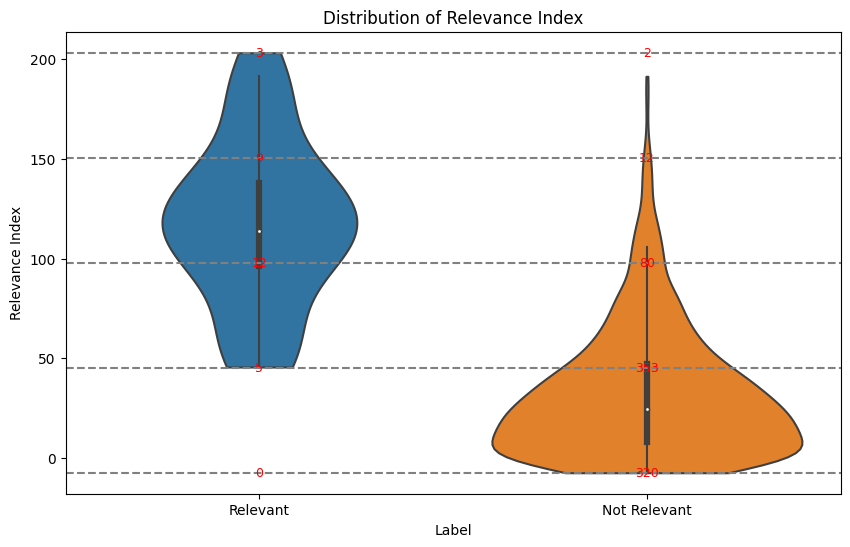

In [46]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Printing the length of lists
print("Numer of relevant literature:", len(relevant_relevance_index_list))
print("Number of not relevant literature:", len(non_relevant_relevance_index_list))
print()

# Create a DataFrame for plotting
df = pd.DataFrame({'Relevance Index': relevant_relevance_index_list + non_relevant_relevance_index_list, 
                   'Label': ['Relevant'] * len(relevant_relevance_index_list) + ['Not Relevant'] * len(non_relevant_relevance_index_list)})

# Draw the violin plot
plt.figure(figsize=(10, 6))
ax = sns.violinplot(x='Label', y='Relevance Index', data=df, bw='scott', cut=0)

relevance_indices = density_display_index  # Replace with your relevance indices

threshold = thres  # Adjust this based on your desired range around the relevance index

for index in relevance_indices:
    ax.axhline(index, color='gray', linestyle='--')
    
    for i, label in enumerate(df['Label'].unique()):
        # Filter data points close to the current relevance index
        close_points = df[(df['Label'] == label) & (np.abs(df['Relevance Index'] - index) < threshold)]
        density = len(close_points)
        
        ax.text(i, index + 0.1, str(density), ha='center', va='center', color='red', fontsize=9)  # adjust the vertical offset (0.1 here) as necessary

plt.title('Distribution of Relevance Index')
plt.show()

In [47]:
import scipy.stats as stats

# Check the equality of variances
var_relevant = np.var(relevant_relevance_index_list)
var_non_relevant = np.var(non_relevant_relevance_index_list)
print('Variance of relevant:', var_relevant)
print('Variance of non-relevant:', var_non_relevant)
print(var_relevant/var_non_relevant)
# statistic, p_value = stats.levene(relevant_relevance_index_list, non_relevant_relevance_index_list)

# # Print the results
# print('Levene test statistic:', statistic)
# print('p-value:', p_value)

Variance of relevant: 1663.6409611782628
Variance of non-relevant: 1074.7862529721253
1.5478807591535222


In [48]:
# Calculate the t-statistic and p-value
t_statistic, p_value = stats.ttest_ind(relevant_relevance_index_list, non_relevant_relevance_index_list)

# Print the results
print('t-statistic:', t_statistic)
print('p-value:', p_value)

t-statistic: 15.150560152064722
p-value: 7.978647828591422e-47


<h3> Next step: manually read papers and find all actually related literature </h3>